In [14]:
# Import parking garage
import MDAnalysis as mda
import MDAnalysisData
import zarr
import h5py
import numcodecs
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
# os.chdir('format_comparison_folder')



In [17]:
# Setup yiip data
yiip = MDAnalysisData.yiip_equilibrium.fetch_yiip_equilibrium_short()
u = mda.Universe(yiip.topology, yiip.trajectory)
positions = mda.Universe(yiip.topology, yiip.trajectory, in_memory=True).trajectory.get_array()

/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following a

In [4]:
# Convenience methods

def generate_traj(n_atoms):
    frames = 100
    pos = np.arange(3 * n_atoms) # this will be initial positions array
    np.random.shuffle(pos)
    pos = pos.reshape(n_atoms, 3)
    positions = np.empty((frames, n_atoms, 3), dtype=np.float32)
    # Each frame we will apply a "jitter" to each position
    # this jitter will be a val between -4 and 4
    jit = 8 * np.random.random_sample((frames, n_atoms, 3)) - 4
    for i in range(frames):
        positions[i] =  jit[i] + pos

    return positions

def filesize(filename):
    return int(subprocess.check_output(['du','-s', filename]).split()[0].decode('utf-8'))

def exponential_range(start, stop, step):
    return [pow(10, i) for i in range(start, stop, step)]


In [11]:
compressor = numcodecs.Blosc(cname='zstd', clevel=9)
compressor2 = numcodecs.Blosc(cname='zstd', clevel=0)

for i in range(3, 7):
    n_atoms = pow(10, i)
    traj = generate_traj(n_atoms)
    u = mda.Universe(traj)

    with mda.Writer(f"10e{i}_xtc.xtc", n_atoms) as w:
        for ts in u.trajectory:
            w.write(u.atoms)

    with mda.Writer(f"10e{i}_trr.trr", n_atoms) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   
    
    with mda.Writer(f"10e{i}_h5md_c.h5md", n_atoms, compression='gzip', compression_ops=9, convert_units=False) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   

    with mda.Writer(f"10e{i}_h5md_un.h5md", n_atoms, convert_units=False) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   

    root = zarr.open(f"10e{i}_zarr_c.zarr", mode='w')
    root.create_dataset('positions', data=traj, 
                        chunks = (1, n_atoms, 3), 
                        compressor=compressor)

    root2 = zarr.open(f"10e{i}_zarr_un.zarr", mode='w')
    root2.create_dataset('positions', data=traj, 
                        chunks = (1, n_atoms, 3), 
                        compressor=compressor2)
    

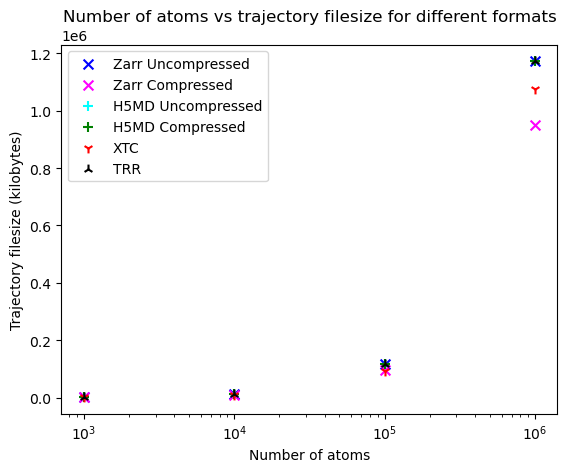

In [26]:
n = np.logspace(3, 6, 4)

x_filesize = []
t_filesize = []
z_filesize = []
z_c_filesize = []
h_filesize =[]
h_c_filesize =[]

for i in range(3, 7, 1):
    x_filesize.append(filesize(f'10e{i}_xtc.xtc'))
    t_filesize.append(filesize(f'10e{i}_trr.trr'))
    z_filesize.append(filesize(f'10e{i}_zarr_un.zarr'))
    z_c_filesize.append(filesize(f'10e{i}_zarr_c.zarr'))
    h_filesize.append(filesize(f'10e{i}_h5md_un.h5md'))
    h_c_filesize.append(filesize(f'10e{i}_h5md_c.h5md'))


# Graph zarrtraj size vs h5 size
plt.title('Number of atoms vs trajectory filesize for different formats')
plt.xlabel('Number of atoms')
plt.ylabel('Trajectory filesize (kilobytes)')
plt.xscale('log')
# plt.yscale('log')

plt.scatter(n, z_filesize, c='blue', s=50, label="Zarr Uncompressed", marker='x')
plt.scatter(n, z_c_filesize, c='magenta', s=50, label="Zarr Compressed", marker='x')
plt.scatter(n, h_filesize, c='cyan', s=50, label="H5MD Uncompressed", marker='+')
plt.scatter(n, z_filesize, c='green', s=50, label="H5MD Compressed", marker='+')
plt.scatter(n, x_filesize, c='red', s=50, label="XTC", marker='1')
plt.scatter(n, t_filesize, c='black', s=50, label="TRR", marker='2')

plt.legend()